# Assigment 6
# Development of optimal smoothing to increase the estimation accuracy

## Team 6: Berman Vladimir, Dronova Maria, Bazhenov Artem, Skoltech, October, 2022

## Initialisation of libraries 

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## Setting functions

In [3]:
# generating velocity vi and acceleration ai
def gnerate_vel_and_ac(exp, var, T, V0, numb):
    arr = np.zeros(numb)
    a = np.random.normal(exp, var ** 0.5, numb)
    arr[0] = V0
    for i in range(1, len(arr)):
        arr[i] = arr[i - 1] + a[i - 1] * T
    return arr, a

# generating coordinate xi 
def generate_x(T, X0, a, v):
    arr = np.zeros(len(a))
    arr[0] = X0
    for i in range(1, len(a)):
        arr[i] = arr[i - 1] + v[i - 1] * T + a[i - 1] * (T ** 2) / 2
    return arr

# Kalman filter
def kalman_filt(z, X0, P0, F, Q, R, H):
    Xii = np.zeros([200, 2])
    Xiin1 = np.zeros([200, 2])
    Piin1 = np.zeros([200, 2 , 2])
    Pii = np.zeros([200, 2 , 2])
    K = np.zeros([200, 2])
    Xii[0] = X0
    Xiin1[0] = X0
    Pii[0] = P0
    Piin1[0] = P0
    for i in range(1, len(X)):
        Xiin1[i] = np.dot(F, Xii[i - 1].reshape(2, 1)).reshape(1, 2)
        Piin1[i] = np.dot(np.dot(F, Pii[i - 1]), F.transpose()) + Q
        K[i] = (Piin1[i].dot(H.reshape(2, 1))).dot((((H.reshape(1,2)).dot(Piin1[i])).dot(H.reshape(2, 1)) + R) ** (-1)).reshape(1, 2)
        Xii[i] = Xiin1[i] + K[i] * (z[i] - np.dot(H, Xiin1[i]))
        Pii[i] = (np.identity(2) - (K[i].reshape(2,1)).dot(H.reshape(1,2))).dot(Piin1[i])
        
    return Xii, Pii, Piin1, K
 
# extrapolation   
def extrapol(x, m, F):
    arr = np.array(x)
    F_pow = np.linalg.matrix_power(F, m - 1)
    for i in range(len(x) - m + 1):
        arr[i + m - 1] = F_pow.dot(x[i])
    return arr

# backward smoothing
def backward_smooth(Xii, F, Pii, Piin1):
    x = np.array(Xii)
    Pn = np.array(Pii)
    A = np.zeros([200, 2, 2])
    for i in range(len(x) - 2, -1, -1):
        A[i] = (Pii[i].dot(F.transpose())).dot(np.linalg.inv(Piin1[i]))
        x[i] = Xii[i] + A[i].dot(x[i + 1] - F.dot(Xii[i]))
        Pn[i] = Pii[i] + (A[i].dot(Pn[i + 1] - Piin1[i])).dot(A[i].transpose())
    return x, Pn

## Generating a true trajectory Xi and measurements zi

In [4]:
x0 = 5
v0 = 1
T = 1
sigmaa_2 = 0.2 ** 2
numb = 200
v,a = gnerate_vel_and_ac(0, sigmaa_2 ** 0.5, T, v0, numb)
x = generate_x(T, x0, a, v)
sigmaeta_2 = 20 ** 2
eta = np.random.normal(0, sigmaeta_2 ** 0.5, 200)
F = np.array([[1, T], [0, 1]])
G = np.array([T ** 2 / 2, T])
H = np.array([1, 0])
z = np.zeros(200)
X = np.zeros([200, 2])
X[0] = np.array([x[0], v[0]])
for i in range(1, len(X)):
    X[i] = np.dot(F, X[i - 1]) + np.dot(G, a[i - 1])
for i in range(len(x)):
    z[i] = np.dot(H, X[i]) + eta[i]
Q = np.dot(np.dot(G, G.transpose()), sigmaa_2)
R = sigmaeta_2
X0 = np.array([5, 1])
P0 = np.array([[10000, 0], [0, 10000]])

## Applying Kalman and backward smoothing

In [5]:
X_filt, Pii, Piin1, K = kalman_filt(z, X0, P0, F, Q, R, H)
X_back, Pn = backward_smooth(X_filt, F, Pii, Piin1)

Text(0.5, 1.0, 'Graph 1\nComparison of forward Kalman filter and backward smoothing')

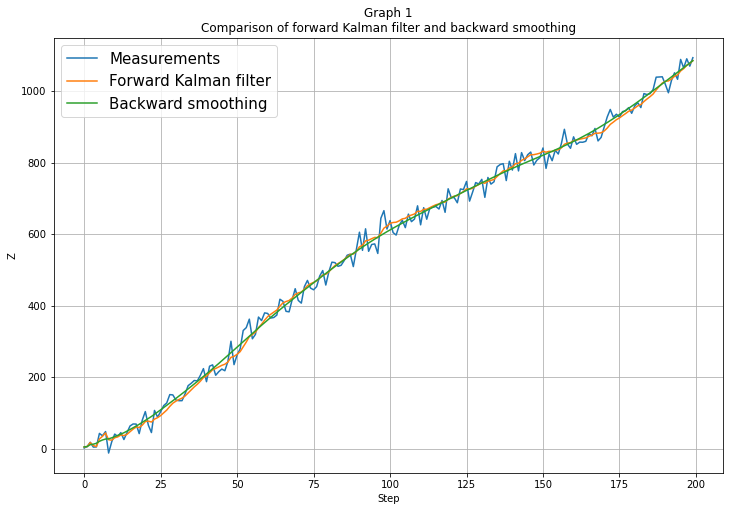

In [6]:
plt.figure(figsize=(12, 8))
plt.plot(z)
plt.plot(X_filt[:, 0])
plt.plot(X_back[:, 0])
plt.grid()
plt.ylabel('Z')
plt.xlabel('Step')
plt.legend(['Measurements','Forward Kalman filter', 'Backward smoothing'], fontsize=15)
plt.title('Graph 1\nComparison of forward Kalman filter and backward smoothing')

### Graph1 shows that apllying backward smoothing allows to get improved estimates of state vector.

## Comparing true estimation error with errors of smoothing Pi,N provided by smoothing algorithm

In [7]:
P = np.zeros([500, 200, 2, 2]) # filtration error covariance matrix 
Pn1 = np.zeros([500, 200, 2, 2]) # prediction error covariance matrix 
Pn = np.zeros([500, 200, 2, 2]) # smoothing error covariance matrix 
P_res = np.zeros([200, 2, 2]) 
P_resn1 = np.zeros([200, 2, 2])
P_resn = np.zeros([200, 2, 2])
err = np.zeros([500, 197, 2])
err_sm = np.zeros([500, 197, 2])
P0 = np.array([[10000, 0], [0, 10000]])
for i in range(500):
    v,a = gnerate_vel_and_ac(0, sigmaa_2 ** 0.5, T, v0, numb)
    X = np.zeros([200, 2])
    X[0] = X0
    for j in range(1, len(X)):
        X[j] = np.dot(F, X[j - 1]) + np.dot(G, a[j - 1])
    z = np.zeros(200)
    eta = np.random.normal(0, sigmaeta_2 ** 0.5, 200)
    for k in range(len(x)):
        z[k] = np.dot(H, X[k]) + eta[k]
    X_filt, P[i], Pn1[i] = kalman_filt(z, X0, P0, F, Q, R, H)[:3]
    X_smooth, Pn[i] = backward_smooth(X_filt, F, P[i], Pn1[i])
    
    err[i] = np.array(X[3:] - X_filt[3:]) ** 2
    err_sm[i] = np.array(X[3:] - X_smooth[3:]) ** 2
final_err = np.zeros([197, 2])
final_err_smooth = np.zeros([197, 2])
for i in range(197):
    final_err[i] = (np.mean(err[:, i])) ** 0.5
for i in range(197):
    final_err_smooth[i] = (np.mean(err_sm[:, i])) ** 0.5
for i in range(200):
    P_res[i] = np.mean(P[:,i])
for i in range(200):
    P_resn1[i] = np.mean(Pn1[:,i])
for i in range(200):
    P_resn[i] = np.mean(Pn[:,i])

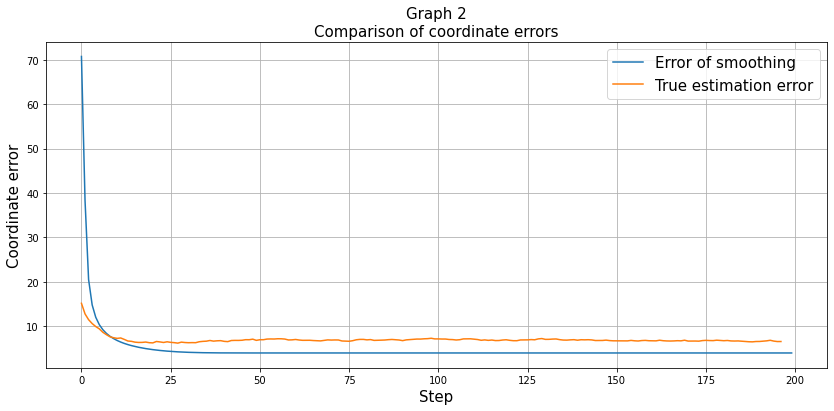

Text(0.5, 1.0, 'Graph 3\nComparison of velocity errors')

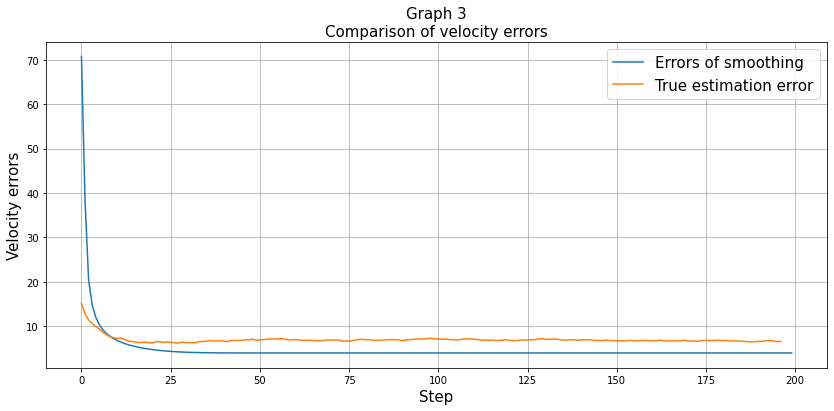

In [77]:
plt.figure(figsize=(14, 6))
plt.plot(P_res[:, 0, 0] ** 0.5)
plt.plot(final_err[:, 0])
plt.grid()
plt.ylabel('Coordinate error', fontsize=15)
plt.xlabel('Step', fontsize=15)
plt.legend(['Error of smoothing','True estimation error'], fontsize=15)
plt.title('Graph 2\nComparison of coordinate errors', fontsize=15)
plt.show()
plt.figure(figsize=(14, 6))
plt.plot(P_res[:, 1, 1] ** 0.5)
plt.plot(final_err[:, 1])
plt.grid()
plt.ylabel('Velocity errors', fontsize=15)
plt.xlabel('Step', fontsize=15)
plt.legend(['Errors of smoothing','True estimation error'], fontsize=15)
plt.title('Graph 3\nComparison of velocity errors', fontsize=15)

### As far as we can see from graphs 2 and 3, smoothing gives big error on first steps of calculation. After approximately 20 steps it stabilizes, as well as true estimation error. Further results almost do not differ. Therefore, we can assume that using backward smoothing (after 15-20 steps) is efficient, but we have to keep in mind that real errors will be slightly bigger that the ones that we can get from smoothing calculations. 

## Comparing smoothing errors of estimation with filtration errors of estimation

C:\Users\Mari_\AppData\Local\Temp\ipykernel_5932\1116642465.py:3: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(P_resn[:, 0, 0] ** 0.5)


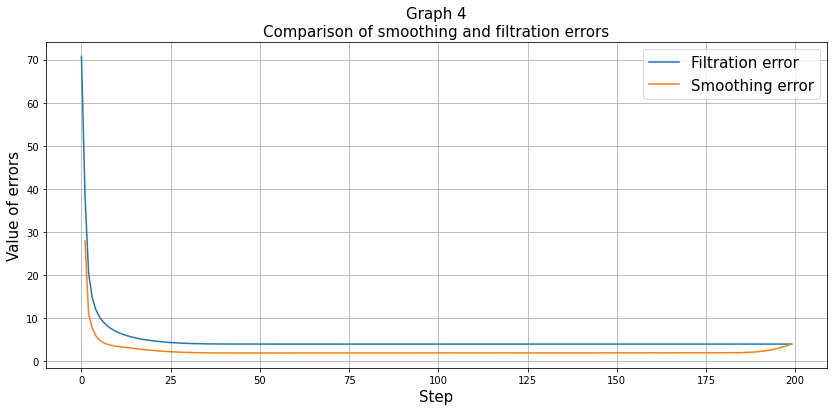

Text(0.5, 1.0, 'Graph 5\nComparison of smoothing and filtration errors')

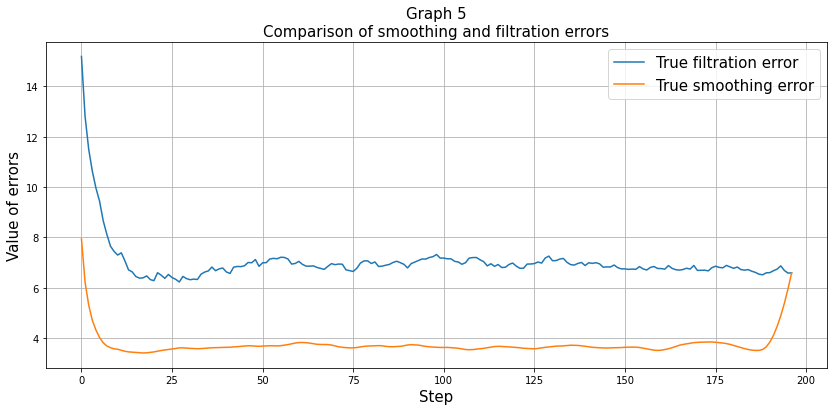

In [78]:
plt.figure(figsize=(14, 6))
plt.plot(P_res[:, 0, 0] ** 0.5)
plt.plot(P_resn[:, 0, 0] ** 0.5)
plt.grid()
plt.ylabel('Value of errors', fontsize=15)
plt.xlabel('Step', fontsize=15)
plt.legend(['Filtration error','Smoothing error'], fontsize=15)
plt.title('Graph 4\nComparison of smoothing and filtration errors', fontsize=15)

plt.show()
plt.figure(figsize=(14, 6))
plt.plot(final_err[:, 0])
plt.plot(final_err_smooth[:, 0])
plt.grid()
plt.ylabel('Value of errors', fontsize=15)
plt.xlabel('Step', fontsize=15)
plt.legend(['True filtration error','True smoothing error'], fontsize=15)
plt.title('Graph 5\nComparison of smoothing and filtration errors', fontsize=15)

### Graphs above indicate that after smoothing of filtrated data errors of estimation are smaller. Real error decreases due to smoothing. 

## Learning log
### Vladimir Berman was generating trajectories for Kalman filter and backward smoothing. 
### Artem Bazhenov wrote functions for filtraion and smoothing.
### Maria Dronova did 500 runs in order to compare errors. Filtrated data errors of estimation are smaller.
### Conclusions were made together after group discussion, then report was made by Maria. 